## import libraries

In [1]:
import os #to use operating system dependent functionality
import glob #to find the pathnames
import numpy as np #to create arrays
import pandas as pd #to create dataframes
import seaborn as sn #to show charts
from PIL import Image #to explore images
from collections import Counter #to create a count-dictionary
import matplotlib.pyplot as plt #to show plots
import tensorflow as tf #for deep learning
from skimage.transform import resize #to resize images
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.preprocessing import LabelBinarizer #to do 1-Hot encoding
from sklearn.model_selection import train_test_split #to split dataset in train-set and test-set
import warnings #to ignore warnings
from sklearn.utils import compute_class_weight #to compute class weights
from keras.metrics import AUC #to import AUC
from tensorflow.keras.models import Sequential #to import class Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D , MaxPooling2D, Flatten #to import keras layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model #to be able to load a model
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve #to import metrics
from sklearn.metrics import confusion_matrix #to import confusion matrix
from sklearn.metrics import classification_report #to show a classification report

Using TensorFlow backend.


## import data

In [2]:
def importing_data(path):
    '''This function is able to import data'''
    data = []
    for filename in glob.glob(path):
        img = Image.open(filename,'r')
        img_array = np.array(img)
        data.append(img_array)
    return data

path1 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\train\NonDemented\*.jpg' 
path2 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\train\VeryMildDemented\*.jpg'
path3 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\train\MildDemented\*.jpg'
path4 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\train\ModerateDemented\*.jpg'
path5 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\test\NonDemented\*.jpg' 
path6 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\test\VeryMildDemented\*.jpg'
path7 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\test\MildDemented\*.jpg'
path8 = r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\test\ModerateDemented\*.jpg'

train_ND = importing_data(path1)
train_VMD = importing_data(path2)
train_MID = importing_data(path3)
train_MOD = importing_data(path4)
test_ND = importing_data(path5)
test_VMD = importing_data(path6)
test_MID = importing_data(path7)
test_MOD = importing_data(path8)

print('Lenghts of Train data are, in order: ' + '\n')
print(len(train_ND), len(train_VMD), len(train_MID),len(train_MOD))
print('Lenghts of Test data are, in order: ' + '\n')
print(len(test_ND),len(test_VMD),len(test_MID),len(test_MOD))

Lenghts of Train data are, in order: 

2560 1792 717 52
Lenghts of Test data are, in order: 

640 448 179 12


Examples of MRI images per class: 



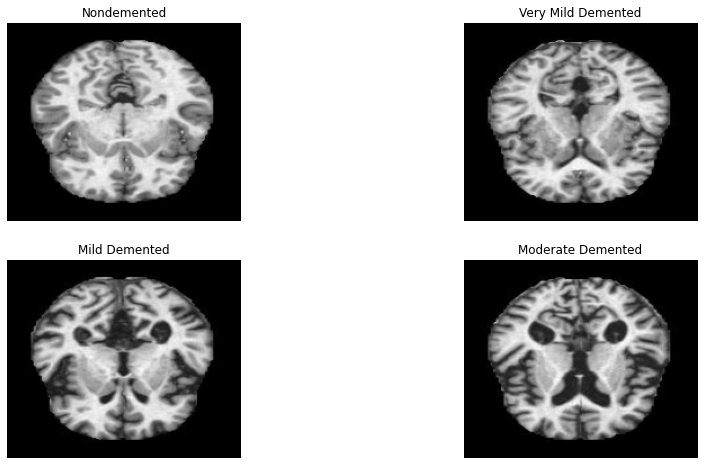

In [5]:
from skimage.transform import resize

def plot_images(img_path):
    '''This function plots an image with a title'''
    new_image = plt.imread(img_path) 
    resized_image = resize(new_image, (176, 208, 3))
    return plt.imshow(resized_image) 

print('Examples of MRI images per class: ' + '\n')
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.title('Nondemented');plt.axis('off');plot_images(r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset\train/NonDemented/nonDem10.jpg')
plt.subplot(222)
plt.title('Very Mild Demented');plt.axis('off');plot_images(r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset/train/VeryMildDemented/verymildDem610.jpg')
plt.subplot(223)
plt.title('Mild Demented');plt.axis('off');plot_images(r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset/train/MildDemented/mildDem107.jpg')
plt.subplot(224)
plt.title('Moderate Demented');plt.axis('off');plot_images(r'C:\Users\italo\OneDrive\Desktop\alzheimer\Alzheimer_s Dataset/train/ModerateDemented/moderateDem16.jpg')
plt.savefig('brains_final')
plt.show()

In [46]:
#merging datasets to obtain the whole dataset (with pandas)

df_train_ND = pd.DataFrame({'image':train_ND, 'label': 'ND'}) #it creates a dataframe
df_train_VMD = pd.DataFrame({'image':train_VMD, 'label': 'VMD'})
df_train_MID = pd.DataFrame({'image':train_MID, 'label': 'MID'})
df_train_MOD = pd.DataFrame({'image':train_MOD, 'label': 'MOD'})
df_test_ND = pd.DataFrame({'image':test_ND, 'label': 'ND'})
df_test_VMD = pd.DataFrame({'image':test_VMD, 'label': 'VMD'})
df_test_MID = pd.DataFrame({'image':test_MID, 'label': 'MID'})
df_test_MOD = pd.DataFrame({'image':test_MOD, 'label': 'MOD'})
final_data = [df_train_ND, df_train_VMD, df_train_MID, df_train_MOD, df_test_ND, df_test_VMD, df_test_MID, df_test_MOD]
final_data = pd.concat(final_data) #it concatenates dataframes 
print('Shape of finale dataframe is: ')
print(final_data.shape)

Shape of finale dataframe is: 
(6400, 2)


## dividing test data and labels

In [47]:
train_data = final_data['image']
labels = final_data['label']
Counter(np.array(labels))

Counter({'ND': 3200, 'VMD': 2240, 'MID': 896, 'MOD': 64})

In [48]:
print(labels)

0      ND
1      ND
2      ND
3      ND
4      ND
     ... 
7     MOD
8     MOD
9     MOD
10    MOD
11    MOD
Name: label, Length: 6400, dtype: object


### as we can see, dataset is very unbalanced so we normalized it

In [49]:
def normalization(array):
    '''This function normalizes train data'''
    train_norm = []
    transformer = MinMaxScaler()
    for value in array:
        value = transformer.fit_transform(value)
        train_norm.append(value)
    return train_norm

train_norm = normalization(train_data)

## Labels 1-Hot 

In [50]:
from sklearn.preprocessing import LabelBinarizer

onehot = LabelBinarizer()
labels = onehot.fit_transform(labels)
print(labels)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_norm, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)
print('length X_train:', len(X_train))
print('length X_test:',  len(X_test))
print('length y_train:', len(y_train))
print('length y_test:', len(y_test))

length X_train: 5120
length X_test: 1280
length y_train: 5120
length y_test: 1280


In [52]:
X_train = np.array(X_train).reshape(5120,208,176,1) #it trasforms in numpy array
X_test = np.array(X_test).reshape(1280,208,176,1)

## computing class weights to combact unbalancing

In [58]:
warnings.filterwarnings("ignore", category=FutureWarning) #to ignore FutureWarning

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print('Dictionary of weights:')
print(d_class_weights)

Dictionary of weights:
{0: 1.7852161785216178, 1: 25.098039215686274, 2: 0.5, 3: 0.7142857142857143}


## building a model

In [61]:
def build_model():
    '''It creates a Sequential model'''
    Cnn = Sequential()
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [208,176,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(4, activation = 'softmax'))
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 104, 88, 64)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 52, 44, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 22, 128)       204928    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 11, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 6, 256)         819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [64]:
import tensorflow

def Model_fit(name):
    '''It fits a model'''
    keras_model = None
    keras_model = build_model()
    '''Compiling the model'''
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='categorical_crossentropy',
                        metrics =['acc', 'AUC'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=10 ,
                   restore_best_weights=True, verbose=1)
    checkpoint_cb = ModelCheckpoint("AD_Stages_model.h5", save_best_only=True)
    history = keras_model.fit(X_train, y_train, validation_split = 0.1,
                    epochs= 100, batch_size = 10, class_weight = d_class_weights ,
                    callbacks=[es, checkpoint_cb])
    keras_model.save('AD_model'+str(name)+'.h5') 
    return history

In [65]:
def CrossVal(n_fold):
    
    cv_results = []
    for i in range(n_fold):
        print("Training on Fold: ",i+1)
        cv_results.append(Model_fit(i))
    return cv_results
        
cv_results = CrossVal(3)

fold1 = cv_results[0]
fold2 = cv_results[1] 
fold3 = cv_results[2]

Training on Fold:  1
Epoch 1/100
461/461 [==============================] - 149s 316ms/step - loss: 1.5438 - acc: 0.3532 - auc: 0.6276 - val_loss: 1.3023 - val_acc: 0.1484 - val_auc: 0.5452
Epoch 2/100
461/461 [==============================] - 145s 315ms/step - loss: 1.3919 - acc: 0.2934 - auc: 0.6243 - val_loss: 1.3104 - val_acc: 0.5078 - val_auc: 0.7639
Epoch 3/100
461/461 [==============================] - 150s 325ms/step - loss: 1.5044 - acc: 0.3937 - auc: 0.6806 - val_loss: 1.2752 - val_acc: 0.3418 - val_auc: 0.6072
Epoch 4/100
461/461 [==============================] - 171s 371ms/step - loss: 1.4558 - acc: 0.3428 - auc: 0.6561 - val_loss: 1.3567 - val_acc: 0.4102 - val_auc: 0.7542
Epoch 5/100
461/461 [==============================] - 183s 397ms/step - loss: 1.4884 - acc: 0.4152 - auc: 0.7033 - val_loss: 1.3104 - val_acc: 0.2832 - val_auc: 0.6662
Epoch 6/100
461/461 [==============================] - 177s 383ms/step - loss: 1.4145 - acc: 0.4551 - auc: 0.7350 - val_loss: 1.2237 -

In [66]:
print('Val_Acc Folder 1: ', max(fold1.history['val_acc']))
print('Val_Acc Folder 2: ', max(fold2.history['val_acc']))
print('Val_Acc Folder 3: ', max(fold3.history['val_acc']))
print('--------------------------------')
print('Val_Auc Folder 1: ', max(fold1.history['val_auc']))
print('Val_Auc Folder 2: ', max(fold2.history['val_auc']))
print('Val_Auc Folder 3: ', max(fold3.history['val_auc']))

Val_Acc Folder 1:  0.98046875
Val_Acc Folder 2:  0.966796875
Val_Acc Folder 3:  0.974609375
--------------------------------
Val_Auc Folder 1:  0.9967060089111328
Val_Auc Folder 2:  0.9944502711296082
Val_Auc Folder 3:  0.994667649269104


In [67]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    '''To plot accuracies and losses'''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

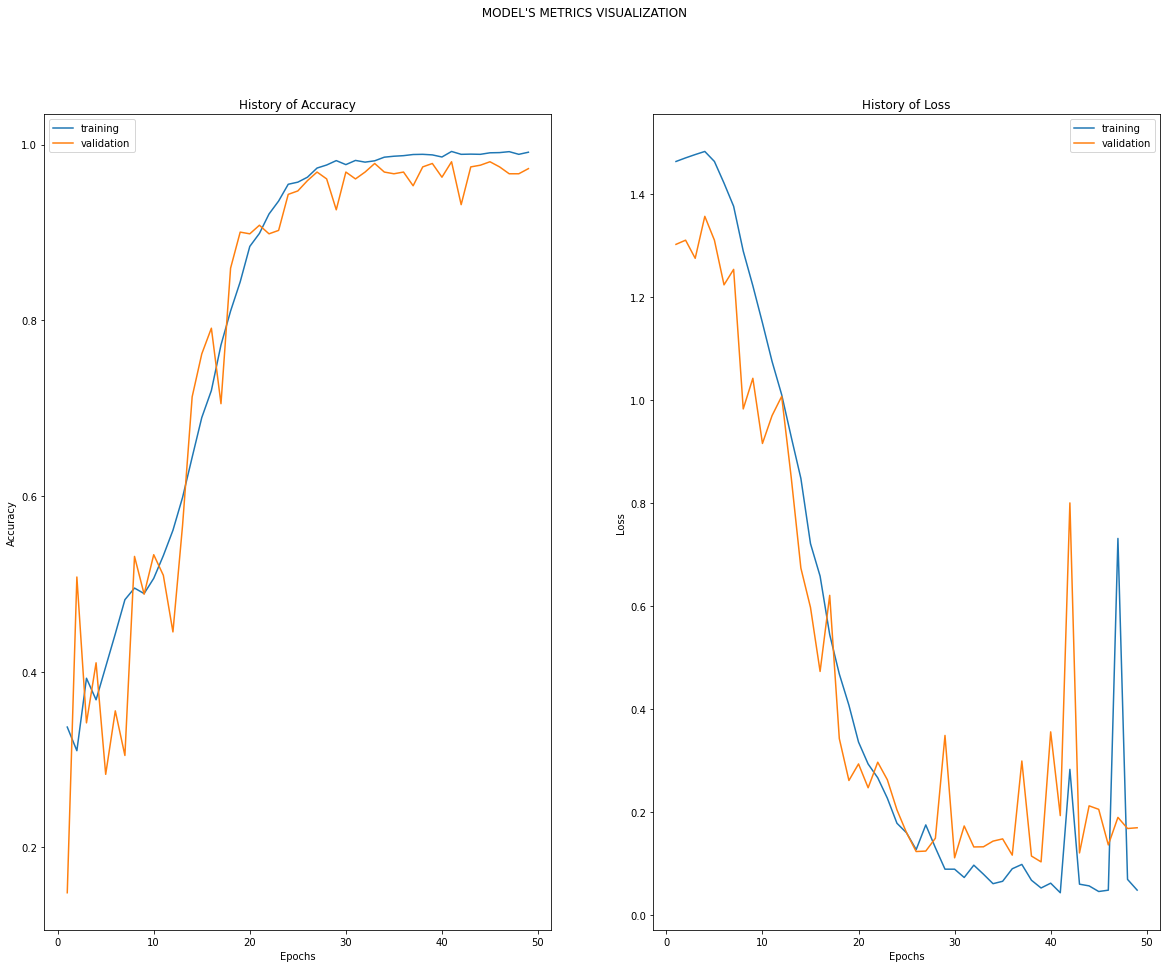

In [68]:
Train_Val_Plot(fold1.history['acc'],fold1.history['val_acc'],
               fold1.history['loss'],fold1.history['val_loss'])

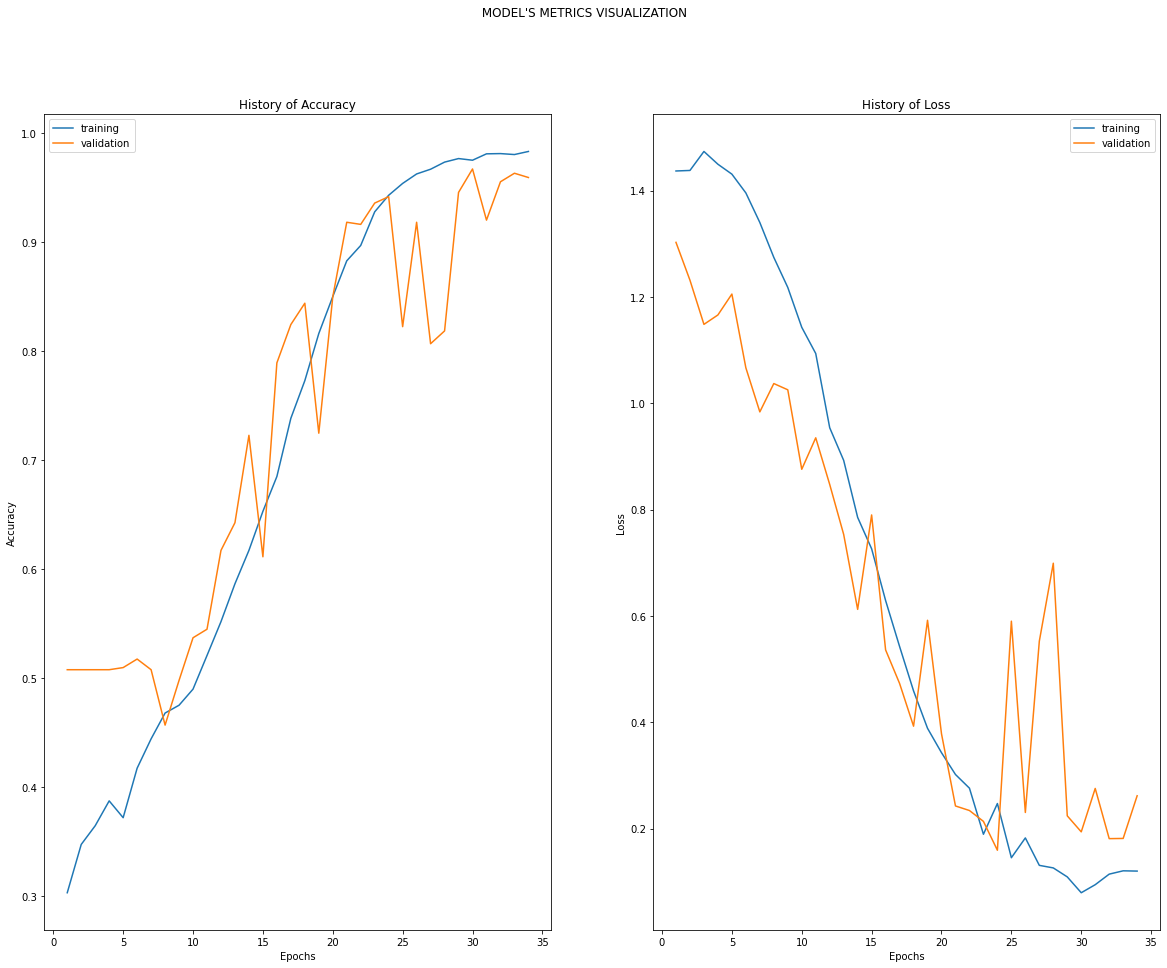

In [69]:
Train_Val_Plot(fold2.history['acc'],fold2.history['val_acc'],
               fold2.history['loss'],fold2.history['val_loss'])

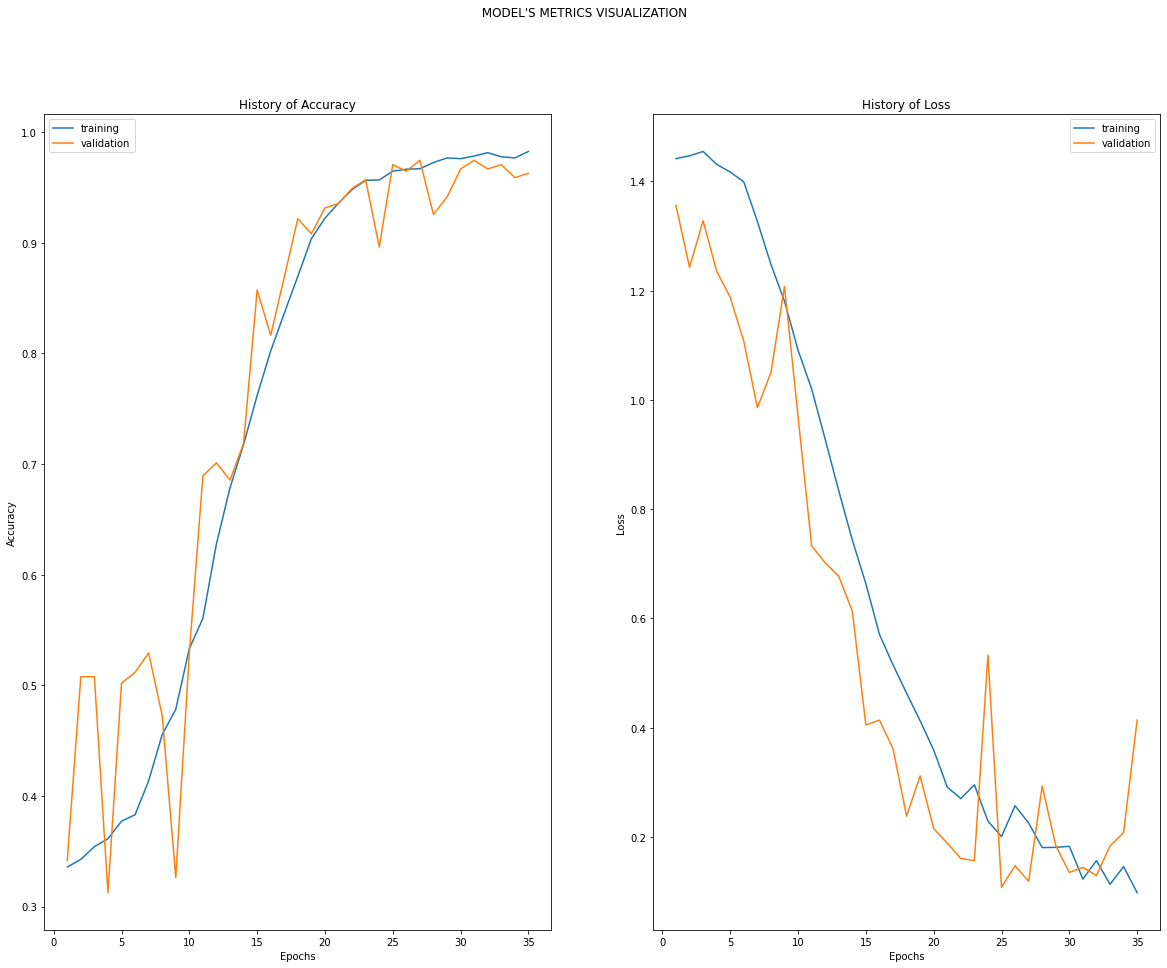

In [70]:
Train_Val_Plot(fold3.history['acc'],fold3.history['val_acc'],
               fold3.history['loss'],fold3.history['val_loss'])

In [72]:
keras_model = tensorflow.keras.models.load_model('AD_model2.h5', compile = False)
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='categorical_crossentropy', metrics =[ 'acc'])

In [74]:
pred_test = keras_model.predict(X_test, verbose = 1)
pred_test = onehot.inverse_transform(pred_test)
real_val = onehot.inverse_transform(y_test)
pred_test_prb= keras_model.predict(X_test)

40/40 [==============================] - 7s 186ms/step


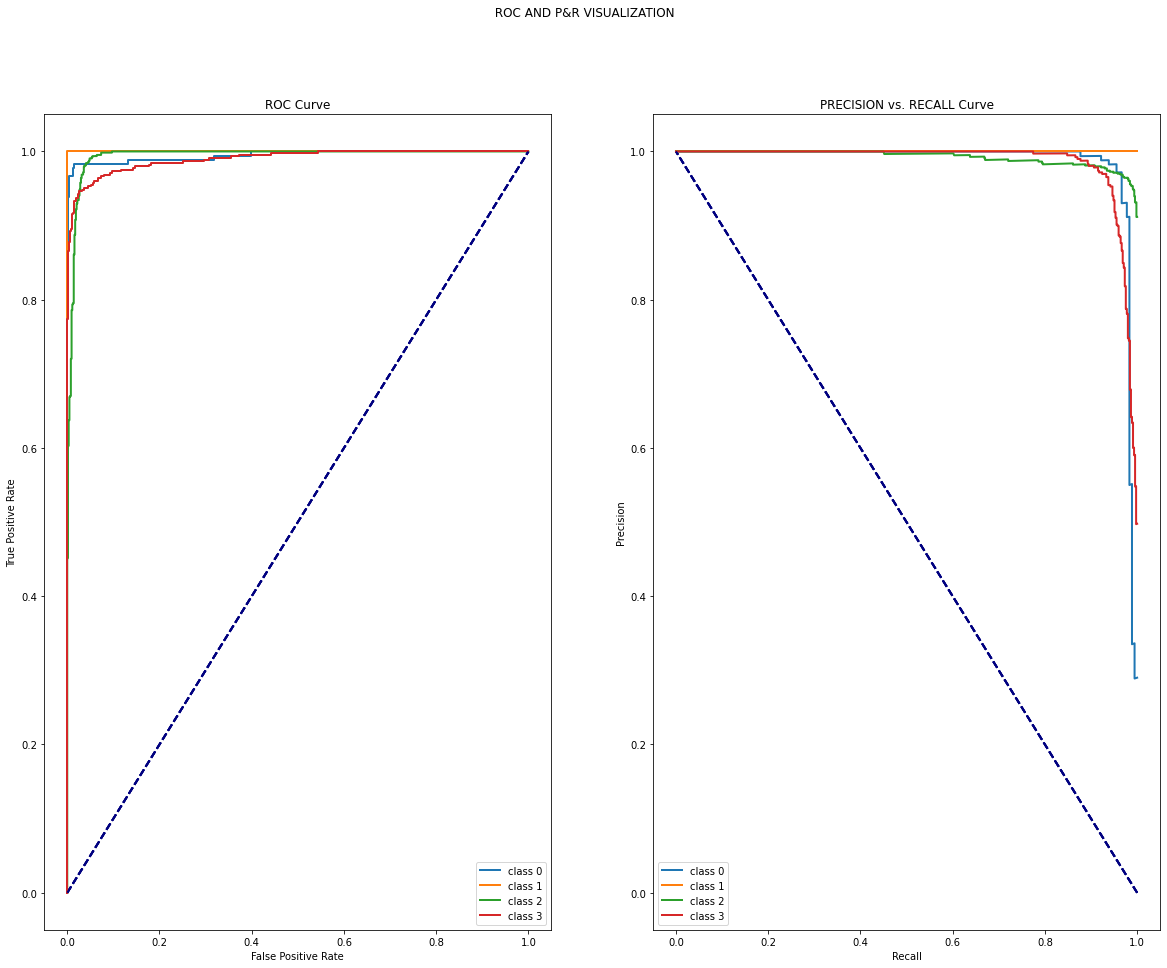

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
fig.suptitle(" ROC AND P&R VISUALIZATION ")

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],pred_test_prb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax1.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax1.set_title("ROC Curve")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend(loc="best")

# Precision-Recall Curve

precision = dict()
recall = dict()

for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], pred_test_prb[:, i])
    ax2.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    ax2.plot([1, 0], [0, 1], color='navy', lw=2, linestyle='--')

ax2.set_title("PRECISION vs. RECALL Curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend(loc="best")

Counter({'ND': 640, 'VMD': 448, 'MID': 179, 'MOD': 13})
Counter({'ND': 664, 'VMD': 421, 'MID': 182, 'MOD': 13})


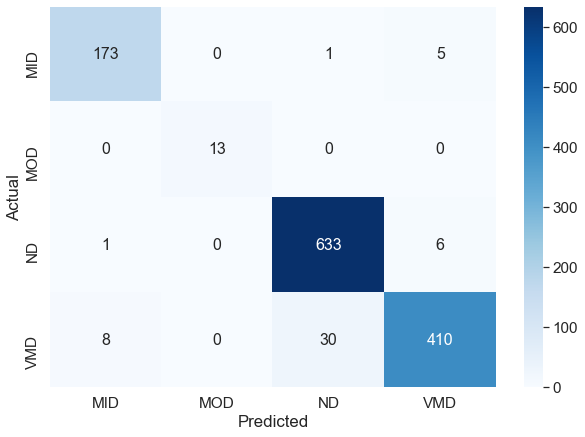

In [76]:
print(Counter(real_val))
print(Counter(pred_test))

conf_mx = confusion_matrix(real_val, pred_test)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(real_val), index = np.unique(real_val))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()

In [82]:
print(classification_report(real_val, pred_test))
print(roc_auc)

              precision    recall  f1-score   support

         MID       0.95      0.97      0.96       179
         MOD       1.00      1.00      1.00        13
          ND       0.95      0.99      0.97       640
         VMD       0.97      0.92      0.94       448

    accuracy                           0.96      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.96      0.96      0.96      1280

{0: 0.9948802256962944, 1: 1.0, 2: 0.9936962890625, 3: 0.9898077996222527}
